In [1]:
import tabula
import numpy as np
import pandas as pd

# Leitura das tabelas do PDF

In [2]:
# Reading all the PDF tables 
table = tabula.read_pdf('sisu-2022-lista-de-espera-ac.pdf', pages='all', guess=False,\
                        multiple_tables=True, area=[195,25,738,557])

In [3]:
len(table)

857

## Separando tabelas em grupos

In [4]:
def table_per_groups(table, split_constraint_column='Classif.'):
    table_per_group = []
    table_ = table[0]
    i = 1
    while i < len(table):
        # When the classification is 1, we have another course
        # if the last page starts with 1, then it has to be grouped after append the last grouped table
        if table[i][split_constraint_column].iloc[0] == 1 and i == len(table)-1:
            table_per_group.append(table_)
            table_per_group.append(table[i])
        elif i == len(table)-1:
            table_ = pd.concat([table_, table[i]])
            table_per_group.append(table_)
        elif table[i][split_constraint_column].iloc[0] == 1:
            table_per_group.append(table_)
            table_ = table[i]
        else:
            table_ = pd.concat([table_, table[i]])
        i += 1
    return table_per_group

In [5]:
table_per_group = table_per_groups(table)

In [6]:
table_per_group[0].head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota,Situação
0,1,211010235888,ANA LUIZA LEMOS DE OLIVEIRA,642.84,CLASSIF
1,2,211015922282,KAIO LUCAS ARAUJO SILVA,642.12,CLASSIF
2,3,211010875618,MIGUEL BARBOSA FARIAS,636.64,CLASSIF
3,4,211005465250,RAONNY DELLANO MACEDO,633.18,CLASSIF
4,5,211015847166,KAIO VIEIRA NUNES,632.72,CLASSIF


## Lendo o texto do PDF de Ampla Concorrência

In [7]:
import io
from PyPDF4 import PdfFileReader, PdfFileWriter
import spacy
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

In [8]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            
        text = fake_file_handle.getvalue()
    
    # close open handles
    converter.close()
    fake_file_handle.close()
    
    if text:
        return text

In [9]:
all_pdf = extract_text_from_pdf('sisu-2022-lista-de-espera-ac.pdf')

### Ao ler os dados do PDF, o retorno fica da seguinte forma

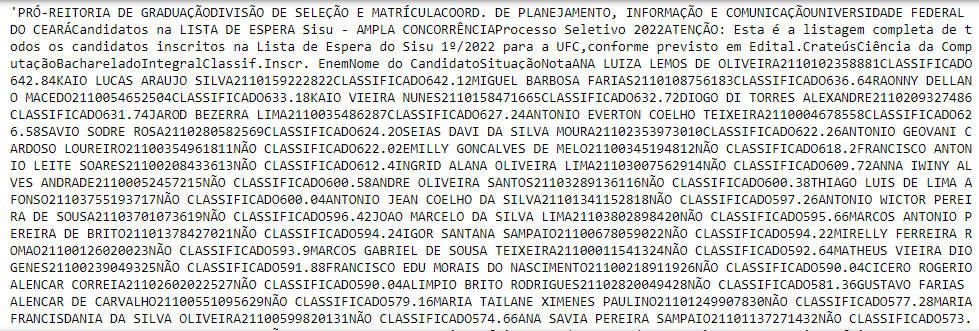

## Extraindo informações adicionais presentes no texto para incluir nas tabelas

In [10]:
def aditional_info_characters(all_pdf, tag_before_info, tag_after_info): # Information in a list of characters
    info_adicional = []
    for index, token in enumerate(all_pdf):
        i = index
        # Procurando os dados de: localidade, curso, bacharelado ou licenciatura, turno e classificação
        if(index >= len(tag_before_info) and index <= len(all_pdf) - (len(tag_after_info)+1)):
            if(str(all_pdf[index-(len(tag_before_info)+1):index-1]) == tag_before_info):
                i = index
                while str(all_pdf[i:i+len(tag_after_info)]) != tag_after_info: # As informações a serem extraídas estão antes das tabelas
                    letra = all_pdf[i-1]
                    info_adicional.append(letra)
                    i += 1
                info_adicional.append(all_pdf[i-1])
                
    return info_adicional

In [11]:
# Aditional information and the parameters are the PDF we search for information and the tags 
# that indicate where the information we want to get are.

aditional_info = aditional_info_characters(all_pdf, 'Edital.', 'Classif.')

In [12]:
def getting_info_string(info_feature, roam_char, aditional_info): 
    feature_token = []
    feature_token.append(aditional_info[roam_char])
    roam_char += 1
    numbers = [str(i) for i in np.arange(0,10)]
    
    # While a sequence of chars is in lowercase the word is not completed
    # Splitting the words based on the first capitalized character to appear in a sequence
    while (aditional_info[roam_char].islower() or aditional_info[roam_char] in numbers) and roam_char < len(aditional_info) - 1:
        feature_token.append(aditional_info[roam_char])
        roam_char += 1
    if(roam_char == len(aditional_info)-1):
        feature_token.append(aditional_info[roam_char])
        roam_char += 1
    
    info_feature.append("".join(feature_token))
    
    return info_feature, roam_char

def info_chars_to_string(aditional_info, cotas_=False): # information in string format
    campus, courses, types, shifts = [], [], [], []
    
    # If cotas=True, we have another information in PDF which is the category of cota
    # and we add another array to compound all necessary information
    if(cotas_):
        cotas = []
        
    roam_char = 0 # Initial state of the variable that roams in aditional info array
    
    while roam_char < len(aditional_info):
        # Taking the information of campus
        campus, roam_char = getting_info_string(campus, roam_char, aditional_info)
        
        # Taking the information of courses
        course_token = []
        course_token.append(aditional_info[roam_char])
        roam_char += 1
        get_course = True
        while get_course:
            # Some courses are in formats like: "Letras (Português-Alemão)"
            if(aditional_info[roam_char+1].isupper() and (aditional_info[roam_char] != ' '\
                                                          and aditional_info[roam_char] != '('\
                                                          and aditional_info[roam_char] != '-')):
                course_token.append(aditional_info[roam_char])
                roam_char += 1
                get_course = False
            else:
                course_token.append(aditional_info[roam_char])
                roam_char += 1
        courses.append("".join(course_token))
        
        # Taking the information of types (Bacharelado or Licenciatura)
        types, roam_char = getting_info_string(types, roam_char, aditional_info)
        
        # Taking the information of shifts (Integral or Noturno)
        shifts, roam_char = getting_info_string(shifts, roam_char, aditional_info)
        
        if(cotas_):
            cotas, roam_char = getting_info_string(cotas, roam_char, aditional_info)
        
    if(cotas_):
        return campus, courses, types, shifts, cotas
    
    return campus, courses, types, shifts

In [13]:
# Storing the information in variables to put them in a dataframe to merge with the candidates table
campus, courses, types, shifts = info_chars_to_string(aditional_info)
to_add_on_tables = np.array([campus, courses, types, shifts, ['Ampla Concorrência']*len(campus)]).T

In [14]:
# Taking the unique values. For each table, all candidates compete in the same category: 
# campus, course, course type, shift and concurrence
to_add_on_tables = pd.DataFrame(to_add_on_tables, columns=['Unidade', 'Curso', 'Tipo Curso', 'Turno', 'Categoria Concorrência'])
to_add_on_tables.drop_duplicates(inplace=True)
to_add_on_tables.head()

,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência
0,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
3,Crateús,Engenharia Ambiental e Sanitária,Bacharelado,Integral,Ampla Concorrência
7,Crateús,Engenharia Civil,Bacharelado,Integral,Ampla Concorrência
11,Crateús,Engenharia de Minas,Bacharelado,Integral,Ampla Concorrência
14,Crateús,Sistemas de Informação,Bacharelado,Integral,Ampla Concorrência


In [15]:
# How many times the unique values have to be repeated to join the both tables: 
# the original tables of PDF and the aditional information we took from PDF
repeats_in_tables = [len(table) for table in table_per_group]
repeated_add_info = pd.DataFrame(np.repeat(to_add_on_tables.values, repeats_in_tables, axis=0), columns=to_add_on_tables.columns)

In [16]:
repeated_add_info.head()

,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência
0,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
1,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
2,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
3,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
4,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência


## Unindo as tabelas extraídas com a informação adicional capturada no PDF

Concatenando as tabelas divididas por curso e resetando o index para fazer o merge no index

In [17]:
table_candidates = pd.concat(table_per_group).reset_index()
# Deleting the 'index' column which refers the position of a candidate in a page, not in a table
del table_candidates['index']

In [18]:
table_candidates = table_candidates.merge(repeated_add_info, left_index=True, right_index=True)

In [19]:
table_candidates.head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota,Situação,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência
0,1,211010235888,ANA LUIZA LEMOS DE OLIVEIRA,642.84,CLASSIF,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
1,2,211015922282,KAIO LUCAS ARAUJO SILVA,642.12,CLASSIF,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
2,3,211010875618,MIGUEL BARBOSA FARIAS,636.64,CLASSIF,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
3,4,211005465250,RAONNY DELLANO MACEDO,633.18,CLASSIF,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência
4,5,211015847166,KAIO VIEIRA NUNES,632.72,CLASSIF,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência


# Executando o código para o PDF de Cotas

In [20]:
# Reading all the PDF tables 
table_cotas = tabula.read_pdf('sisu-2022-lista-de-espera-cotas.pdf', pages='all', guess=False,\
                              area=[210,24,740,594])

In [21]:
table_cotas[0].head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota Situação
0,1,211010875618,MIGUEL BARBOSA FARIAS,636.64 CLASSIFICADO NA AC
1,2,211000467855,ANTONIO EVERTON COELHO TEIXEIRA,626.58 CLASSIFICADO NA AC
2,3,211000115413,MARCOS GABRIEL DE SOUSA TEIXEIRA,592.64 NÃO CLASSIFICADO
3,4,211026020225,CICERO ROGERIO ALENCAR CORREIA,590.04 NÃO CLASSIFICADO
4,5,211000759558,LIVIA COELHO MUNIZ,573.62 NÃO CLASSIFICADO


In [22]:
# Some tables were not read correctly, like table_cotas[1], we have to split the 3st column which is
# not standardized, the correct number of columns is 5, when a table has less then 5, we need to std
#column_names=['Classif.', 'Inscr. Enem', 'Nome do Candidato', 'Nota', 'Situação']
def standardize_tables(tables, len_columns, not_std_column, column_names=['Classif.', 'Inscr. Enem', 'Nome do Candidato', 'Nota', 'Situação']):
    for i in range(len(tables)):
        if len(tables[i].columns) < len_columns:
            # n delimites the ' ' we want to consider to split, as we want to split in the first ' ', n=1
            split_i = tables[i][tables[i].columns[-1]].str.split(' ', n=1, expand=True)
            tables[i] = pd.merge(tables[i], split_i, left_index=True, right_index=True)
            tables[i] = tables[i].drop([not_std_column], axis=1)
        tables[i].columns = column_names
    
    return tables

In [23]:
# Standardizing tables and dividing them per cota/course
table_cotas = standardize_tables(table_cotas, 5, 'Nota Situação')
# Dividing the groups in course/cota
table_per_group_cotas = table_per_groups(table_cotas)

In [24]:
table_per_group_cotas[0].head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota,Situação
0,1,211010875618,MIGUEL BARBOSA FARIAS,636.64,CLASSIFICADO NA AC
1,2,211000467855,ANTONIO EVERTON COELHO TEIXEIRA,626.58,CLASSIFICADO NA AC
2,3,211000115413,MARCOS GABRIEL DE SOUSA TEIXEIRA,592.64,NÃO CLASSIFICADO
3,4,211026020225,CICERO ROGERIO ALENCAR CORREIA,590.04,NÃO CLASSIFICADO
4,5,211000759558,LIVIA COELHO MUNIZ,573.62,NÃO CLASSIFICADO


In [25]:
all_pdf_cotas = extract_text_from_pdf('sisu-2022-lista-de-espera-cotas.pdf')

In [26]:
aditional_info_cotas = aditional_info_characters(all_pdf_cotas, 'Edital.', 'Classif.')

In [27]:
# Storing the information in variables to put them in a dataframe to merge with the candidates table
campus_, courses_, types_, shifts_, cotas_ = info_chars_to_string(aditional_info_cotas, cotas_=True)
to_add_on_tables_cotas = np.array([campus_, courses_, types_, shifts_, cotas_]).T

In [28]:
# Taking the unique values. For each table, all candidates compete in the same category: 
# campus, course, course type, shift and concurrence
to_add_on_tables_cotas = pd.DataFrame(to_add_on_tables_cotas, columns=['Unidade', 'Curso', 'Tipo Curso', 'Turno', 'Categoria Concorrência'])
to_add_on_tables_cotas.drop_duplicates(inplace=True)
to_add_on_tables_cotas.head()

,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência
0,Crateús,Ciência da Computação,Bacharelado,Integral,L1
1,Crateús,Ciência da Computação,Bacharelado,Integral,L2
2,Crateús,Ciência da Computação,Bacharelado,Integral,L5
3,Crateús,Ciência da Computação,Bacharelado,Integral,L6
4,Crateús,Engenharia Ambiental e Sanitária,Bacharelado,Integral,L1


In [29]:
# How many times the unique values have to be repeated to join the both tables: 
# the original tables of PDF and the aditional information we took from PDF
repeats_in_tables_cotas = [len(table) for table in table_per_group_cotas]
repeated_add_info_cotas = pd.DataFrame(np.repeat(to_add_on_tables_cotas.values, repeats_in_tables_cotas, axis=0), columns=to_add_on_tables_cotas.columns)

In [30]:
table_candidates_cotas = pd.concat(table_per_group_cotas).reset_index()
# Deleting the 'index' column which refers the position of a candidate in a page, not in a table
del table_candidates_cotas['index']

In [31]:
table_candidates_cotas = table_candidates_cotas.merge(repeated_add_info_cotas, left_index=True, right_index=True)

In [32]:
table_candidates_cotas.head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota,Situação,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência
0,1,211010875618,MIGUEL BARBOSA FARIAS,636.64,CLASSIFICADO NA AC,Crateús,Ciência da Computação,Bacharelado,Integral,L1
1,2,211000467855,ANTONIO EVERTON COELHO TEIXEIRA,626.58,CLASSIFICADO NA AC,Crateús,Ciência da Computação,Bacharelado,Integral,L1
2,3,211000115413,MARCOS GABRIEL DE SOUSA TEIXEIRA,592.64,NÃO CLASSIFICADO,Crateús,Ciência da Computação,Bacharelado,Integral,L1
3,4,211026020225,CICERO ROGERIO ALENCAR CORREIA,590.04,NÃO CLASSIFICADO,Crateús,Ciência da Computação,Bacharelado,Integral,L1
4,5,211000759558,LIVIA COELHO MUNIZ,573.62,NÃO CLASSIFICADO,Crateús,Ciência da Computação,Bacharelado,Integral,L1


In [33]:
final_table = pd.concat([table_candidates, table_candidates_cotas]).reset_index()
final_table = final_table[['Classif.', 'Inscr. Enem', 'Nome do Candidato', 'Nota', 'Unidade', 'Curso', 'Tipo Curso', 'Turno', 'Categoria Concorrência', 'Situação']]

final_table.to_csv('resultado_lista_de_espera.csv')

In [34]:
final_table.head()

,Classif.,Inscr. Enem,Nome do Candidato,Nota,Unidade,Curso,Tipo Curso,Turno,Categoria Concorrência,Situação
0,1,211010235888,ANA LUIZA LEMOS DE OLIVEIRA,642.84,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência,CLASSIF
1,2,211015922282,KAIO LUCAS ARAUJO SILVA,642.12,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência,CLASSIF
2,3,211010875618,MIGUEL BARBOSA FARIAS,636.64,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência,CLASSIF
3,4,211005465250,RAONNY DELLANO MACEDO,633.18,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência,CLASSIF
4,5,211015847166,KAIO VIEIRA NUNES,632.72,Crateús,Ciência da Computação,Bacharelado,Integral,Ampla Concorrência,CLASSIF


In [35]:
final_table.describe()

,Classif.,Inscr. Enem
count,42287.000000,4.228700e+04
mean,186.445834,2.111117e+11
std,304.199463,6.761101e+08
min,1.000000,2.020002e+11
25%,23.000000,2.110042e+11
50%,75.000000,2.110111e+11
75%,210.000000,2.110216e+11
max,2141.000000,2.150028e+11
